# Instrumentación de Entrenamiento de Modelo de ML con MLflow
## Ubicación: notebooks/oil_prices_mlflow.ipynb
## Alumno David Plaza Cuéllar

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
import requests
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Configurar MLflow
mlflow.set_tracking_uri("http://localhost:5000")  # Ruta seleccionada para ejecutar MLflow
mlflow.set_experiment("Prediccion_Precios_Petroleo")

<Experiment: artifact_location='mlflow-artifacts:/559960264491972670', creation_time=1740897011716, experiment_id='559960264491972670', last_update_time=1740897011716, lifecycle_stage='active', name='Prediccion_Precios_Petroleo', tags={}>

# 1. Descargar y cargar el dataset

In [10]:
# Crear directorio data/raw si no existe
os.makedirs('../data/raw', exist_ok=True)

In [12]:
# Ruta al archivo parquet
parquet_url = "https://huggingface.co/datasets/harishb00/daily-oil-prices/resolve/refs%2Fconvert%2Fparquet/default/train/0000.parquet"
local_parquet_path = "../data/raw/oil_prices.parquet"

In [13]:
# Descargar el archivo parquet si no existe localmente
if not os.path.exists(local_parquet_path):
    print("Descargando el dataset...")
    response = requests.get(parquet_url)
    with open(local_parquet_path, 'wb') as f:
        f.write(response.content)
    print(f"Dataset descargado y guardado en {local_parquet_path}")
else:
    print(f"Dataset ya existe en {local_parquet_path}")

Dataset ya existe en ../data/raw/oil_prices.parquet


In [14]:
# Cargar el dataset
df = pd.read_parquet(local_parquet_path)

# 2. Análisis Exploratorio de Datos (EDA)

In [15]:
print("=== Información del Dataset ===")
print(f"Forma del dataset: {df.shape}")
print("\nPrimeras 5 filas:")
print(df.head())

print("\nInformación del dataset:")
print(df.info())

print("\nEstadísticas descriptivas:")
print(df.describe())


=== Información del Dataset ===
Forma del dataset: (9560, 2)

Primeras 5 filas:
         Date  Price
0  1987-05-20  18.63
1  1987-05-21  18.45
2  1987-05-22  18.55
3  1987-05-25  18.60
4  1987-05-26  18.63

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9560 entries, 0 to 9559
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9560 non-null   object 
 1   Price   9560 non-null   float64
dtypes: float64(1), object(1)
memory usage: 149.5+ KB
None

Estadísticas descriptivas:
             Price
count  9560.000000
mean     50.326313
std      32.853756
min       9.100000
25%      19.380000
50%      43.560000
75%      74.772500
max     143.950000


In [16]:

# Verificar valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())



Valores nulos por columna:
Date     0
Price    0
dtype: int64


In [52]:

# Verificar duplicados
print("\nFilas duplicadas:")
print(df.duplicated().sum())


Filas duplicadas:
0


# 3. Preprocesamiento de datos

In [17]:
# Convertir la columna Date a formato datetime
df['Date'] = pd.to_datetime(df['Date'])

In [18]:
# Ordenar por fecha
df = df.sort_values('Date')

In [19]:
# Eliminar valores nulos si existen
if df.isnull().sum().sum() > 0:
    print("Eliminando valores nulos...")
    df = df.dropna()
    print(f"Forma del dataset después de eliminar nulos: {df.shape}")

In [20]:
# Crear características adicionales basadas en la fecha
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Quarter'] = df['Date'].dt.quarter

In [21]:
# Crear características de rezago (lag features)
# El rezago de 1 día es demasiado predictivo y causa overfitting
for lag in range(2, 8):  # Crear rezagos de 2 a 7 días
    df[f'Price_Lag_{lag}'] = df['Price'].shift(lag)

In [22]:
# Crear características de promedio móvil
# Agregamos un día de rezago para evitar incluir el día actual en los promedios
for window in [7, 14, 30]:
    df[f'Price_Rolling_{window}'] = df['Price'].shift(1).rolling(window=window).mean()

In [23]:
# Eliminar filas con NaN resultantes de la creación de características
df = df.dropna()

In [24]:
# Visualizaciones exploratorias
plt.figure(figsize=(15, 8))

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

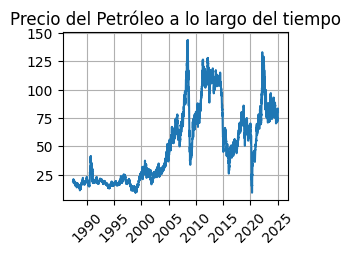

In [61]:
# Serie de tiempo completa
plt.subplot(2, 2, 1)
plt.plot(df['Date'], df['Price'])
plt.title('Precio del Petróleo a lo largo del tiempo')
plt.xticks(rotation=45)
plt.grid(True)

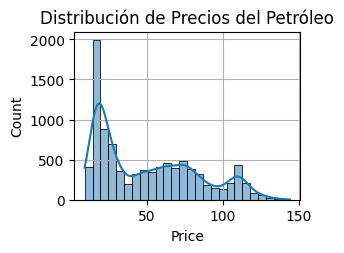

In [62]:
# Histograma de precios
plt.subplot(2, 2, 2)
sns.histplot(df['Price'], kde=True)
plt.title('Distribución de Precios del Petróleo')
plt.grid(True)


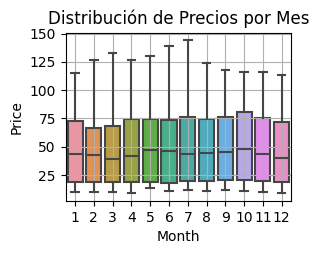

In [63]:
# Boxplot por mes
plt.subplot(2, 2, 3)
sns.boxplot(x='Month', y='Price', data=df)
plt.title('Distribución de Precios por Mes')
plt.grid(True)

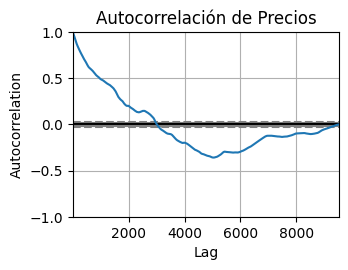

In [64]:
# Autocorrelación
plt.subplot(2, 2, 4)
pd.plotting.autocorrelation_plot(df['Price'])
plt.title('Autocorrelación de Precios')
plt.grid(True)

plt.tight_layout()
plt.savefig('../reports/figures/eda_visualization.png', dpi=300)
plt.show()

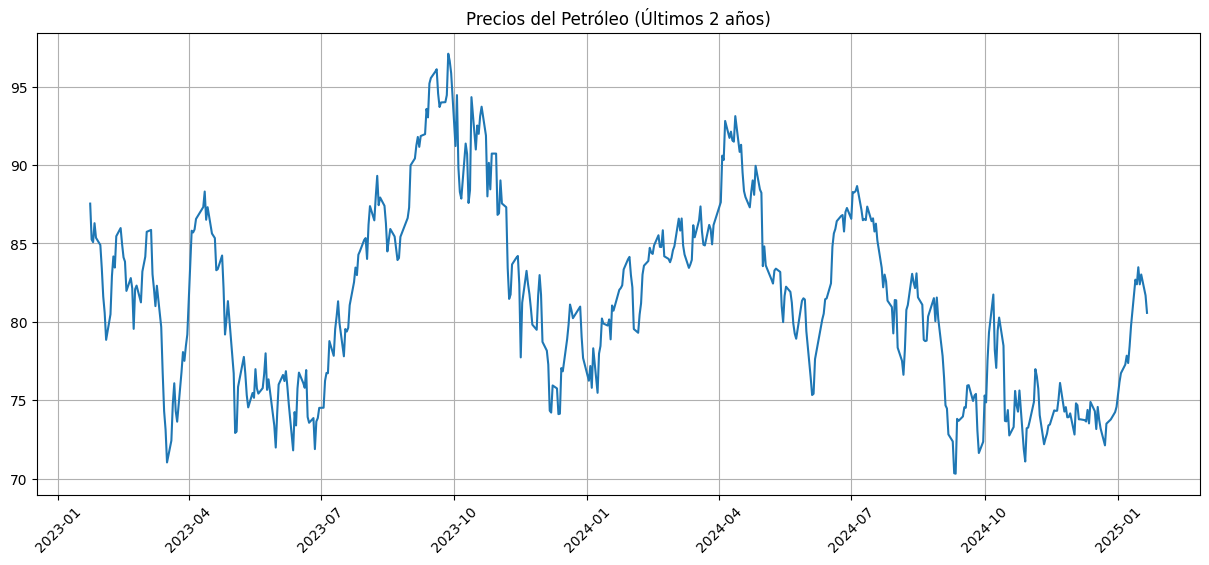

In [65]:
# Gráfico de la serie temporal reciente (últimos 2 años)
plt.figure(figsize=(15, 6))
recent_data = df[df['Date'] > (df['Date'].max() - timedelta(days=730))]
plt.plot(recent_data['Date'], recent_data['Price'])
plt.title('Precios del Petróleo (Últimos 2 años)')
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig('../reports/figures/recent_prices.png', dpi=300)
plt.show()

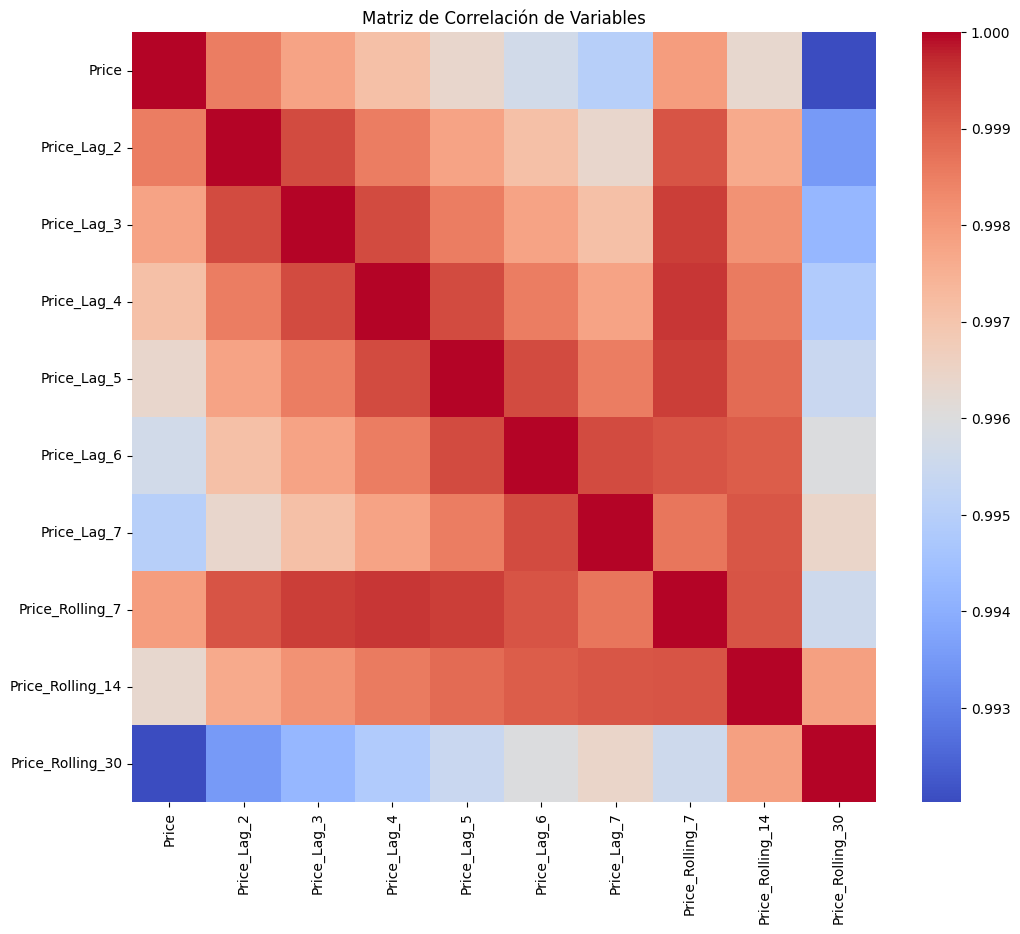

In [66]:
# Correlación entre características
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 10))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Variables')
plt.savefig('../reports/figures/correlation_matrix.png', dpi=300)
plt.show()

# 4. Preparación de datos para el entrenamiento

In [25]:
# Para problemas de series temporales, se separan los datos por fecha
# Se utilizan los datos hasta cierta fecha para entrenamiento y los posteriores para prueba
split_date = df['Date'].max() - timedelta(days=365)  # Último año para test
train_df = df[df['Date'] <= split_date]
test_df = df[df['Date'] > split_date]

print(f"\nConjunto de entrenamiento: {train_df.shape}")
print(f"Conjunto de prueba: {test_df.shape}")


Conjunto de entrenamiento: (9277, 16)
Conjunto de prueba: (253, 16)


In [26]:
# Definir características y variable objetivo
feature_cols = [col for col in df.columns if col not in ['Date', 'Price']]

In [27]:
# Calcular correlaciones entre características para identificar multicolinealidad
correlation_matrix = train_df[feature_cols].corr().abs()
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"\nCaracterísticas con alta correlación (>0.95): {high_corr_features}")

# Eliminar características altamente correlacionadas para reducir multicolinealidad
for feature in high_corr_features:
    if feature in feature_cols:
        feature_cols.remove(feature)
        print(f"Eliminando: {feature} debido a alta correlación con otras características")

X_train = train_df[feature_cols]
y_train = train_df['Price']
X_test = test_df[feature_cols]
y_test = test_df['Price']


Características con alta correlación (>0.95): ['Quarter', 'Price_Lag_3', 'Price_Lag_4', 'Price_Lag_5', 'Price_Lag_6', 'Price_Lag_7', 'Price_Rolling_7', 'Price_Rolling_14', 'Price_Rolling_30']
Eliminando: Quarter debido a alta correlación con otras características
Eliminando: Price_Lag_3 debido a alta correlación con otras características
Eliminando: Price_Lag_4 debido a alta correlación con otras características
Eliminando: Price_Lag_5 debido a alta correlación con otras características
Eliminando: Price_Lag_6 debido a alta correlación con otras características
Eliminando: Price_Lag_7 debido a alta correlación con otras características
Eliminando: Price_Rolling_7 debido a alta correlación con otras características
Eliminando: Price_Rolling_14 debido a alta correlación con otras características
Eliminando: Price_Rolling_30 debido a alta correlación con otras características


In [28]:
# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Entrenamiento y evaluación de modelos con MLflow

In [29]:
# Se utilizará TimeSeriesSplit para la validación cruzada
tscv = TimeSeriesSplit(n_splits=5)

In [30]:
# Modelo 1: Linear Regression
with mlflow.start_run(run_name="Linear_Regression_Model"):
    # Registrar parámetros
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_param("n_splits", 5)
    
    # Calcular correlación entre características y objetivo
    print("\n=== Correlación de Características con Precio ===")
    corr_with_target = pd.DataFrame(
        {'feature': feature_cols, 
         'correlation': [np.corrcoef(X_train[col], y_train)[0, 1] for col in feature_cols]}
    ).sort_values('correlation', ascending=False)
    print(corr_with_target.head(10))
    
    # Listas para almacenar métricas en cada fold
    train_mse_list = []
    val_mse_list = []
    train_mae_list = []
    val_mae_list = []
    train_r2_list = []
    val_r2_list = []
    
    fold = 1
    
    # Realizar validación cruzada de series temporales
    for train_idx, val_idx in tscv.split(X_train_scaled):
        # Dividir datos para este fold
        X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Crear y entrenar el modelo
        model = LinearRegression()
        model.fit(X_train_fold, y_train_fold)
        
        # Predicciones
        y_train_pred = model.predict(X_train_fold)
        y_val_pred = model.predict(X_val_fold)
        
        # Calcular métricas
        train_mse = mean_squared_error(y_train_fold, y_train_pred)
        val_mse = mean_squared_error(y_val_fold, y_val_pred)
        train_mae = mean_absolute_error(y_train_fold, y_train_pred)
        val_mae = mean_absolute_error(y_val_fold, y_val_pred)
        train_r2 = r2_score(y_train_fold, y_train_pred)
        val_r2 = r2_score(y_val_fold, y_val_pred)
        
        # Almacenar métricas
        train_mse_list.append(train_mse)
        val_mse_list.append(val_mse)
        train_mae_list.append(train_mae)
        val_mae_list.append(val_mae)
        train_r2_list.append(train_r2)
        val_r2_list.append(val_r2)
        
        # Registrar métricas para este fold
        mlflow.log_metric(f"fold_{fold}_train_mse", train_mse)
        mlflow.log_metric(f"fold_{fold}_val_mse", val_mse)
        mlflow.log_metric(f"fold_{fold}_train_mae", train_mae)
        mlflow.log_metric(f"fold_{fold}_val_mae", val_mae)
        mlflow.log_metric(f"fold_{fold}_train_r2", train_r2)
        mlflow.log_metric(f"fold_{fold}_val_r2", val_r2)
        
        fold += 1
    
    # Calcular promedios
    avg_train_mse = np.mean(train_mse_list)
    avg_val_mse = np.mean(val_mse_list)
    avg_train_mae = np.mean(train_mae_list)
    avg_val_mae = np.mean(val_mae_list)
    avg_train_r2 = np.mean(train_r2_list)
    avg_val_r2 = np.mean(val_r2_list)
    
    # Registrar métricas promedio
    mlflow.log_metric("avg_train_mse", avg_train_mse)
    mlflow.log_metric("avg_val_mse", avg_val_mse)
    mlflow.log_metric("avg_train_mae", avg_train_mae)
    mlflow.log_metric("avg_val_mae", avg_val_mae)
    mlflow.log_metric("avg_train_r2", avg_train_r2)
    mlflow.log_metric("avg_val_r2", avg_val_r2)
    
    # Crear gráficas de métricas
    epochs = list(range(1, 6))  # 5 folds
    
    # Gráfica MSE (función de costo)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_mse_list, 'b-', label='Training MSE')
    plt.plot(epochs, val_mse_list, 'r-', label='Validation MSE')
    plt.title('Mean Squared Error por Fold')
    plt.xlabel('Fold')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.savefig('../reports/figures/lr_mse.png', dpi=300)
    plt.close()
    
    # Gráfica MAE (métrica de desempeño 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_mae_list, 'b-', label='Training MAE')
    plt.plot(epochs, val_mae_list, 'r-', label='Validation MAE')
    plt.title('Mean Absolute Error por Fold')
    plt.xlabel('Fold')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.savefig('../reports/figures/lr_mae.png', dpi=300)
    plt.close()
    
    # Gráfica R2 (métrica de desempeño 2)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_r2_list, 'b-', label='Training R²')
    plt.plot(epochs, val_r2_list, 'r-', label='Validation R²')
    plt.title('R² Score por Fold')
    plt.xlabel('Fold')
    plt.ylabel('R²')
    plt.legend()
    plt.grid(True)
    plt.savefig('../reports/figures/lr_r2.png', dpi=300)
    plt.close()
    
    # Registrar gráficas en MLflow
    mlflow.log_artifact('../reports/figures/lr_mse.png')
    mlflow.log_artifact('../reports/figures/lr_mae.png')
    mlflow.log_artifact('../reports/figures/lr_r2.png')
    
    # Entrenar el modelo final con todos los datos de entrenamiento
    final_model = LinearRegression()
    final_model.fit(X_train_scaled, y_train)
    
    # Evaluar en el conjunto de prueba
    y_test_pred = final_model.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Registrar métricas de prueba
    mlflow.log_metric("test_mse", test_mse)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("test_r2", test_r2)
    
    # Registrar el modelo
    mlflow.sklearn.log_model(final_model, "linear_regression_model")
    
    # Visualizar predicciones vs valores reales en el conjunto de prueba
    plt.figure(figsize=(12, 6))
    plt.plot(test_df['Date'], y_test, 'b-', label='Valores Reales')
    plt.plot(test_df['Date'], y_test_pred, 'r-', label='Predicciones')
    plt.title('Linear Regression: Predicciones vs Valores Reales')
    plt.xlabel('Fecha')
    plt.ylabel('Precio del Petróleo')
    plt.legend()
    plt.grid(True)
    plt.savefig('../reports/figures/lr_predictions.png', dpi=300)
    plt.close()
    
    # Registrar gráfica de predicciones
    mlflow.log_artifact('../reports/figures/lr_predictions.png')
    
    # Imprimir resultados
    print("\n=== Resultados de Linear Regression ===")
    print(f"MSE Promedio (Train): {avg_train_mse:.2f}")
    print(f"MSE Promedio (Validación): {avg_val_mse:.2f}")
    print(f"MSE (Test): {test_mse:.2f}")
    print(f"MAE Promedio (Train): {avg_train_mae:.2f}")
    print(f"MAE Promedio (Validación): {avg_val_mae:.2f}")
    print(f"MAE (Test): {test_mae:.2f}")
    print(f"R² Promedio (Train): {avg_train_r2:.4f}")
    print(f"R² Promedio (Validación): {avg_val_r2:.4f}")
    print(f"R² (Test): {test_r2:.4f}")


=== Correlación de Características con Precio ===
       feature  correlation
4  Price_Lag_2     0.998543
0         Year     0.729078
1        Month     0.003587
3    DayOfWeek     0.003159
2          Day    -0.000427

=== Resultados de Linear Regression ===
MSE Promedio (Train): 1.27
MSE Promedio (Validación): 3.66
MSE (Test): 3.61
MAE Promedio (Train): 0.66
MAE Promedio (Validación): 1.28
MAE (Test): 1.49
R² Promedio (Train): 0.9835
R² Promedio (Validación): 0.9853
R² (Test): 0.8775


In [31]:
# Modelo 2: Random Forest Regressor
with mlflow.start_run(run_name="Random_Forest_Model"):
    # Registrar parámetros - ajustando para reducir overfitting
    n_estimators = 100
    max_depth = 6  # Reducido para disminuir overfitting
    min_samples_split = 5  # Aumentado para reducir overfitting
    min_samples_leaf = 4  # Mínimo de muestras en hojas para generalizar mejor
    
    mlflow.log_param("model_type", "RandomForestRegressor")
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("min_samples_split", min_samples_split)
    mlflow.log_param("n_splits", 5)
    
    # Listas para almacenar métricas en cada fold
    train_mse_list = []
    val_mse_list = []
    train_mae_list = []
    val_mae_list = []
    train_r2_list = []
    val_r2_list = []
    
    fold = 1
    # Realizar validación cruzada de series temporales
    for train_idx, val_idx in tscv.split(X_train_scaled):
        # Dividir datos para este fold
        X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Crear y entrenar el modelo
        model = RandomForestRegressor(
            n_estimators=n_estimators, 
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        model.fit(X_train_fold, y_train_fold)
        
        # Predicciones
        y_train_pred = model.predict(X_train_fold)
        y_val_pred = model.predict(X_val_fold)
        
        # Calcular métricas
        train_mse = mean_squared_error(y_train_fold, y_train_pred)
        val_mse = mean_squared_error(y_val_fold, y_val_pred)
        train_mae = mean_absolute_error(y_train_fold, y_train_pred)
        val_mae = mean_absolute_error(y_val_fold, y_val_pred)
        train_r2 = r2_score(y_train_fold, y_train_pred)
        val_r2 = r2_score(y_val_fold, y_val_pred)
        
        # Almacenar métricas
        train_mse_list.append(train_mse)
        val_mse_list.append(val_mse)
        train_mae_list.append(train_mae)
        val_mae_list.append(val_mae)
        train_r2_list.append(train_r2)
        val_r2_list.append(val_r2)
        
        # Registrar métricas para este fold
        mlflow.log_metric(f"fold_{fold}_train_mse", train_mse)
        mlflow.log_metric(f"fold_{fold}_val_mse", val_mse)
        mlflow.log_metric(f"fold_{fold}_train_mae", train_mae)
        mlflow.log_metric(f"fold_{fold}_val_mae", val_mae)
        mlflow.log_metric(f"fold_{fold}_train_r2", train_r2)
        mlflow.log_metric(f"fold_{fold}_val_r2", val_r2)
        
        fold += 1
    
    # Calcular promedios
    avg_train_mse = np.mean(train_mse_list)
    avg_val_mse = np.mean(val_mse_list)
    avg_train_mae = np.mean(train_mae_list)
    avg_val_mae = np.mean(val_mae_list)
    avg_train_r2 = np.mean(train_r2_list)
    avg_val_r2 = np.mean(val_r2_list)
    
    # Registrar métricas promedio
    mlflow.log_metric("avg_train_mse", avg_train_mse)
    mlflow.log_metric("avg_val_mse", avg_val_mse)
    mlflow.log_metric("avg_train_mae", avg_train_mae)
    mlflow.log_metric("avg_val_mae", avg_val_mae)
    mlflow.log_metric("avg_train_r2", avg_train_r2)
    mlflow.log_metric("avg_val_r2", avg_val_r2)
    
    # Crear gráficas de métricas
    epochs = list(range(1, 6))  # 5 folds
    
    # Gráfica MSE (función de costo)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_mse_list, 'b-', label='Training MSE')
    plt.plot(epochs, val_mse_list, 'r-', label='Validation MSE')
    plt.title('Mean Squared Error por Fold')
    plt.xlabel('Fold')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.savefig('../reports/figures/rf_mse.png', dpi=300)
    plt.close()
    
    # Gráfica MAE (métrica de desempeño 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_mae_list, 'b-', label='Training MAE')
    plt.plot(epochs, val_mae_list, 'r-', label='Validation MAE')
    plt.title('Mean Absolute Error por Fold')
    plt.xlabel('Fold')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.savefig('../reports/figures/rf_mae.png', dpi=300)
    plt.close()
    
    # Gráfica R2 (métrica de desempeño 2)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_r2_list, 'b-', label='Training R²')
    plt.plot(epochs, val_r2_list, 'r-', label='Validation R²')
    plt.title('R² Score por Fold')
    plt.xlabel('Fold')
    plt.ylabel('R²')
    plt.legend()
    plt.grid(True)
    plt.savefig('../reports/figures/rf_r2.png', dpi=300)
    plt.close()
    
    # Registrar gráficas en MLflow
    mlflow.log_artifact('../reports/figures/rf_mse.png')
    mlflow.log_artifact('../reports/figures/rf_mae.png')
    mlflow.log_artifact('../reports/figures/rf_r2.png')
    
    # Entrenar el modelo final con todos los datos de entrenamiento
    final_model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    final_model.fit(X_train_scaled, y_train)
    
    # Evaluar en el conjunto de prueba
    y_test_pred = final_model.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Registrar métricas de prueba
    mlflow.log_metric("test_mse", test_mse)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("test_r2", test_r2)
    
    # Visualizar predicciones vs valores reales en el conjunto de prueba
    plt.figure(figsize=(12, 6))
    plt.plot(test_df['Date'], y_test, 'b-', label='Valores Reales')
    plt.plot(test_df['Date'], y_test_pred, 'r-', label='Predicciones')
    plt.title('Random Forest: Predicciones vs Valores Reales')
    plt.xlabel('Fecha')
    plt.ylabel('Precio del Petróleo')
    plt.legend()
    plt.grid(True)
    plt.savefig('../reports/figures/rf_predictions.png', dpi=300)
    plt.close()
    
    # Registrar gráfica de predicciones
    mlflow.log_artifact('../reports/figures/rf_predictions.png')
    
    # Registrar importancia de características
    feature_importance = pd.DataFrame(
        {'feature': feature_cols, 'importance': final_model.feature_importances_}
    ).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Importancia de Características (Random Forest)')
    plt.tight_layout()
    plt.savefig('../reports/figures/feature_importance.png', dpi=300)
    plt.close()
    
    # Registrar importancia de características
    mlflow.log_artifact('../reports/figures/feature_importance.png')
    
    # Registrar el modelo
    mlflow.sklearn.log_model(final_model, "random_forest_model")
    
    # Imprimir resultados
    print("\n=== Resultados de Random Forest ===")
    print(f"MSE Promedio (Train): {avg_train_mse:.2f}")
    print(f"MSE Promedio (Validación): {avg_val_mse:.2f}")
    print(f"MSE (Test): {test_mse:.2f}")
    print(f"MAE Promedio (Train): {avg_train_mae:.2f}")
    print(f"MAE Promedio (Validación): {avg_val_mae:.2f}")
    print(f"MAE (Test): {test_mae:.2f}")
    print(f"R² Promedio (Train): {avg_train_r2:.4f}")
    print(f"R² Promedio (Validación): {avg_val_r2:.4f}")
    print(f"R² (Test): {test_r2:.4f}")


=== Resultados de Random Forest ===
MSE Promedio (Train): 1.04
MSE Promedio (Validación): 160.54
MSE (Test): 3.72
MAE Promedio (Train): 0.61
MAE Promedio (Validación): 5.22
MAE (Test): 1.52
R² Promedio (Train): 0.9884
R² Promedio (Validación): 0.6213
R² (Test): 0.8737


In [32]:
# Modelo 3: Gradient Boosting Regressor
with mlflow.start_run(run_name="Gradient_Boosting_Model"):
    # Registrar parámetros
    n_estimators = 100
    max_depth = 5
    learning_rate = 0.1
    min_samples_split = 5
    
    mlflow.log_param("model_type", "GradientBoostingRegressor")
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("min_samples_split", min_samples_split)
    mlflow.log_param("n_splits", 5)
    
    # Listas para almacenar métricas en cada fold
    train_mse_list = []
    val_mse_list = []
    train_mae_list = []
    val_mae_list = []
    train_r2_list = []
    val_r2_list = []
    
    fold = 1
    # Realizar validación cruzada de series temporales
    for train_idx, val_idx in tscv.split(X_train_scaled):
        # Dividir datos para este fold
        X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Crear y entrenar el modelo
        model = GradientBoostingRegressor(
            n_estimators=n_estimators, 
            max_depth=max_depth,
            learning_rate=learning_rate,
            min_samples_split=min_samples_split,
            random_state=42
        )
        model.fit(X_train_fold, y_train_fold)
        
        # Predicciones
        y_train_pred = model.predict(X_train_fold)
        y_val_pred = model.predict(X_val_fold)
        
        # Calcular métricas
        train_mse = mean_squared_error(y_train_fold, y_train_pred)
        val_mse = mean_squared_error(y_val_fold, y_val_pred)
        train_mae = mean_absolute_error(y_train_fold, y_train_pred)
        val_mae = mean_absolute_error(y_val_fold, y_val_pred)
        train_r2 = r2_score(y_train_fold, y_train_pred)
        val_r2 = r2_score(y_val_fold, y_val_pred)
        
        # Almacenar métricas
        train_mse_list.append(train_mse)
        val_mse_list.append(val_mse)
        train_mae_list.append(train_mae)
        val_mae_list.append(val_mae)
        train_r2_list.append(train_r2)
        val_r2_list.append(val_r2)
        
        # Registrar métricas para este fold
        mlflow.log_metric(f"fold_{fold}_train_mse", train_mse)
        mlflow.log_metric(f"fold_{fold}_val_mse", val_mse)
        mlflow.log_metric(f"fold_{fold}_train_mae", train_mae)
        mlflow.log_metric(f"fold_{fold}_val_mae", val_mae)
        mlflow.log_metric(f"fold_{fold}_train_r2", train_r2)
        mlflow.log_metric(f"fold_{fold}_val_r2", val_r2)
        
        fold += 1
    
    # Calcular promedios
    avg_train_mse = np.mean(train_mse_list)
    avg_val_mse = np.mean(val_mse_list)
    avg_train_mae = np.mean(train_mae_list)
    avg_val_mae = np.mean(val_mae_list)
    avg_train_r2 = np.mean(train_r2_list)
    avg_val_r2 = np.mean(val_r2_list)
    
    # Registrar métricas promedio
    mlflow.log_metric("avg_train_mse", avg_train_mse)
    mlflow.log_metric("avg_val_mse", avg_val_mse)
    mlflow.log_metric("avg_train_mae", avg_train_mae)
    mlflow.log_metric("avg_val_mae", avg_val_mae)
    mlflow.log_metric("avg_train_r2", avg_train_r2)
    mlflow.log_metric("avg_val_r2", avg_val_r2)
    
    # Crear gráficas de métricas
    epochs = list(range(1, 6))  # 5 folds
    
    # Gráfica MSE (función de costo)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_mse_list, 'b-', label='Training MSE')
    plt.plot(epochs, val_mse_list, 'r-', label='Validation MSE')
    plt.title('Mean Squared Error por Fold')
    plt.xlabel('Fold')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.savefig('../reports/figures/gb_mse.png', dpi=300)
    plt.close()
    
    # Gráfica MAE (métrica de desempeño 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_mae_list, 'b-', label='Training MAE')
    plt.plot(epochs, val_mae_list, 'r-', label='Validation MAE')
    plt.title('Mean Absolute Error por Fold')
    plt.xlabel('Fold')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.savefig('../reports/figures/gb_mae.png', dpi=300)
    plt.close()
    
    # Gráfica R2 (métrica de desempeño 2)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_r2_list, 'b-', label='Training R²')
    plt.plot(epochs, val_r2_list, 'r-', label='Validation R²')
    plt.title('R² Score por Fold')
    plt.xlabel('Fold')
    plt.ylabel('R²')
    plt.legend()
    plt.grid(True)
    plt.savefig('../reports/figures/gb_r2.png', dpi=300)
    plt.close()
    
    # Registrar gráficas en MLflow
    mlflow.log_artifact('../reports/figures/gb_mse.png')
    mlflow.log_artifact('../reports/figures/gb_mae.png')
    mlflow.log_artifact('../reports/figures/gb_r2.png')
    
    # Entrenar el modelo final con todos los datos de entrenamiento
    final_model = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_samples_split=min_samples_split,
        random_state=42
    )
    
    final_model.fit(X_train_scaled, y_train)
    
    # Evaluar en el conjunto de prueba
    y_test_pred = final_model.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Registrar métricas de prueba
    mlflow.log_metric("test_mse", test_mse)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("test_r2", test_r2)
    
    # Visualizar predicciones vs valores reales en el conjunto de prueba
    plt.figure(figsize=(12, 6))
    plt.plot(test_df['Date'], y_test, 'b-', label='Valores Reales')
    plt.plot(test_df['Date'], y_test_pred, 'r-', label='Predicciones')
    plt.title('Gradient Boosting: Predicciones vs Valores Reales')
    plt.xlabel('Fecha')
    plt.ylabel('Precio del Petróleo')
    plt.legend()
    plt.grid(True)
    plt.savefig('../reports/figures/gb_predictions.png', dpi=300)
    plt.close()
    
    # Registrar gráfica de predicciones
    mlflow.log_artifact('../reports/figures/gb_predictions.png')
    
    # Registrar importancia de características
    feature_importance = pd.DataFrame(
        {'feature': feature_cols, 'importance': final_model.feature_importances_}
    ).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Importancia de Características (Gradient Boosting)')
    plt.tight_layout()
    plt.savefig('../reports/figures/gb_feature_importance.png', dpi=300)
    plt.close()
    
    # Registrar importancia de características
    mlflow.log_artifact('../reports/figures/gb_feature_importance.png')
    
    # Registrar el modelo
    mlflow.sklearn.log_model(final_model, "gradient_boosting_model")
    
    # Imprimir resultados
    print("\n=== Resultados de Gradient Boosting ===")
    print(f"MSE Promedio (Train): {avg_train_mse:.2f}")
    print(f"MSE Promedio (Validación): {avg_val_mse:.2f}")
    print(f"MSE (Test): {test_mse:.2f}")
    print(f"MAE Promedio (Train): {avg_train_mae:.2f}")
    print(f"MAE Promedio (Validación): {avg_val_mae:.2f}")
    print(f"MAE (Test): {test_mae:.2f}")
    print(f"R² Promedio (Train): {avg_train_r2:.4f}")
    print(f"R² Promedio (Validación): {avg_val_r2:.4f}")
    print(f"R² (Test): {test_r2:.4f}")


=== Resultados de Gradient Boosting ===
MSE Promedio (Train): 0.66
MSE Promedio (Validación): 172.84
MSE (Test): 4.10
MAE Promedio (Train): 0.51
MAE Promedio (Validación): 5.74
MAE (Test): 1.56
R² Promedio (Train): 0.9951
R² Promedio (Validación): 0.5793
R² (Test): 0.8606


In [33]:
# Modelo 4: Support Vector Regression (SVR)
with mlflow.start_run(run_name="SVR_Model"):
    # Registrar parámetros
    C = 10.0
    epsilon = 0.1
    kernel = 'rbf'
    gamma = 'scale'
    
    mlflow.log_param("model_type", "SVR")
    mlflow.log_param("C", C)
    mlflow.log_param("epsilon", epsilon)
    mlflow.log_param("kernel", kernel)
    mlflow.log_param("gamma", gamma)
    mlflow.log_param("n_splits", 5)
    
    # Listas para almacenar métricas en cada fold
    train_mse_list = []
    val_mse_list = []
    train_mae_list = []
    val_mae_list = []
    train_r2_list = []
    val_r2_list = []
    
    fold = 1
    # Realizar validación cruzada de series temporales
    for train_idx, val_idx in tscv.split(X_train_scaled):
        # Dividir datos para este fold
        X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Usar una muestra más pequeña para SVR por eficiencia (si hay muchos datos)
        if len(X_train_fold) > 1000:
            sample_size = min(1000, len(X_train_fold))
            sample_indices = np.random.choice(len(X_train_fold), sample_size, replace=False)
            X_train_fold_sample = X_train_fold[sample_indices]
            y_train_fold_sample = y_train_fold.iloc[sample_indices]
        else:
            X_train_fold_sample = X_train_fold
            y_train_fold_sample = y_train_fold
        
        # Crear y entrenar el modelo
        model = SVR(
            C=C,
            epsilon=epsilon,
            kernel=kernel,
            gamma=gamma
        )
        model.fit(X_train_fold_sample, y_train_fold_sample)
        
        # Predicciones
        y_train_pred = model.predict(X_train_fold_sample)
        y_val_pred = model.predict(X_val_fold)
        
        # Calcular métricas
        train_mse = mean_squared_error(y_train_fold_sample, y_train_pred)
        val_mse = mean_squared_error(y_val_fold, y_val_pred)
        train_mae = mean_absolute_error(y_train_fold_sample, y_train_pred)
        val_mae = mean_absolute_error(y_val_fold, y_val_pred)
        train_r2 = r2_score(y_train_fold_sample, y_train_pred)
        val_r2 = r2_score(y_val_fold, y_val_pred)
        
        # Almacenar métricas
        train_mse_list.append(train_mse)
        val_mse_list.append(val_mse)
        train_mae_list.append(train_mae)
        val_mae_list.append(val_mae)
        train_r2_list.append(train_r2)
        val_r2_list.append(val_r2)
        
        # Registrar métricas para este fold
        mlflow.log_metric(f"fold_{fold}_train_mse", train_mse)
        mlflow.log_metric(f"fold_{fold}_val_mse", val_mse)
        mlflow.log_metric(f"fold_{fold}_train_mae", train_mae)
        mlflow.log_metric(f"fold_{fold}_val_mae", val_mae)
        mlflow.log_metric(f"fold_{fold}_train_r2", train_r2)
        mlflow.log_metric(f"fold_{fold}_val_r2", val_r2)
        
        fold += 1
    
    # Calcular promedios
    avg_train_mse = np.mean(train_mse_list)
    avg_val_mse = np.mean(val_mse_list)
    avg_train_mae = np.mean(train_mae_list)
    avg_val_mae = np.mean(val_mae_list)
    avg_train_r2 = np.mean(train_r2_list)
    avg_val_r2 = np.mean(val_r2_list)
    
    # Registrar métricas promedio
    mlflow.log_metric("avg_train_mse", avg_train_mse)
    mlflow.log_metric("avg_val_mse", avg_val_mse)
    mlflow.log_metric("avg_train_mae", avg_train_mae)
    mlflow.log_metric("avg_val_mae", avg_val_mae)
    mlflow.log_metric("avg_train_r2", avg_train_r2)
    mlflow.log_metric("avg_val_r2", avg_val_r2)
    
    # Crear gráficas de métricas
    epochs = list(range(1, 6))  # 5 folds
    
    # Gráfica MSE (función de costo)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_mse_list, 'b-', label='Training MSE')
    plt.plot(epochs, val_mse_list, 'r-', label='Validation MSE')
    plt.title('Mean Squared Error por Fold')
    plt.xlabel('Fold')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.savefig('../reports/figures/svr_mse.png', dpi=300)
    plt.close()
    
    # Gráfica MAE (métrica de desempeño 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_mae_list, 'b-', label='Training MAE')
    plt.plot(epochs, val_mae_list, 'r-', label='Validation MAE')
    plt.title('Mean Absolute Error por Fold')
    plt.xlabel('Fold')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.savefig('../reports/figures/svr_mae.png', dpi=300)
    plt.close()
    
    # Gráfica R2 (métrica de desempeño 2)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_r2_list, 'b-', label='Training R²')
    plt.plot(epochs, val_r2_list, 'r-', label='Validation R²')
    plt.title('R² Score por Fold')
    plt.xlabel('Fold')
    plt.ylabel('R²')
    plt.legend()
    plt.grid(True)
    plt.savefig('../reports/figures/svr_r2.png', dpi=300)
    plt.close()
    
    # Registrar gráficas en MLflow
    mlflow.log_artifact('../reports/figures/svr_mse.png')
    mlflow.log_artifact('../reports/figures/svr_mae.png')
    mlflow.log_artifact('../reports/figures/svr_r2.png')
    
    # Entrenar el modelo final con todos los datos de entrenamiento (usar una muestra para eficiencia)
    if len(X_train_scaled) > 1000:
        sample_size = 1000  # Limitar a 1000 muestras para entrenar SVR por eficiencia
        sample_indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
        X_train_sample = X_train_scaled[sample_indices]
        y_train_sample = y_train.iloc[sample_indices]
    else:
        X_train_sample = X_train_scaled
        y_train_sample = y_train
    
    final_model = SVR(
        C=C,
        epsilon=epsilon,
        kernel=kernel,
        gamma=gamma
    )
    
    final_model.fit(X_train_sample, y_train_sample)
    
    # Evaluar en el conjunto de prueba
    y_test_pred = final_model.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Registrar métricas de prueba
    mlflow.log_metric("test_mse", test_mse)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("test_r2", test_r2)
    
    # Visualizar predicciones vs valores reales en el conjunto de prueba
    plt.figure(figsize=(12, 6))
    plt.plot(test_df['Date'], y_test, 'b-', label='Valores Reales')
    plt.plot(test_df['Date'], y_test_pred, 'r-', label='Predicciones')
    plt.title('SVR: Predicciones vs Valores Reales')
    plt.xlabel('Fecha')
    plt.ylabel('Precio del Petróleo')
    plt.legend()
    plt.grid(True)
    plt.savefig('../reports/figures/svr_predictions.png', dpi=300)
    plt.close()
    
    # Registrar gráfica de predicciones
    mlflow.log_artifact('../reports/figures/svr_predictions.png')
    
    # Registrar el modelo
    mlflow.sklearn.log_model(final_model, "svr_model")
    
    # Imprimir resultados
    print("\n=== Resultados de SVR ===")
    print(f"MSE Promedio (Train): {avg_train_mse:.2f}")
    print(f"MSE Promedio (Validación): {avg_val_mse:.2f}")
    print(f"MSE (Test): {test_mse:.2f}")
    print(f"MAE Promedio (Train): {avg_train_mae:.2f}")
    print(f"MAE Promedio (Validación): {avg_val_mae:.2f}")
    print(f"MAE (Test): {test_mae:.2f}")
    print(f"R² Promedio (Train): {avg_train_r2:.4f}")
    print(f"R² Promedio (Validación): {avg_val_r2:.4f}")
    print(f"R² (Test): {test_r2:.4f}")


=== Resultados de SVR ===
MSE Promedio (Train): 2.86
MSE Promedio (Validación): 279.49
MSE (Test): 7.50
MAE Promedio (Train): 0.83
MAE Promedio (Validación): 8.28
MAE (Test): 2.23
R² Promedio (Train): 0.9773
R² Promedio (Validación): 0.3525
R² (Test): 0.7451


In [34]:
# Crear visualización comparativa de modelos
test_predictions = {
    'Fecha': test_df['Date'],
    'Reales': y_test,
    'Linear Regression': LinearRegression().fit(X_train_scaled, y_train).predict(X_test_scaled),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42).fit(X_train_scaled, y_train).predict(X_test_scaled),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42).fit(X_train_scaled, y_train).predict(X_test_scaled)
    # SVR se excluye de esta comparación rápida debido a su alto costo computacional
}

In [35]:
# Crear un DataFrame para facilitar la visualización
pred_df = pd.DataFrame(test_predictions)

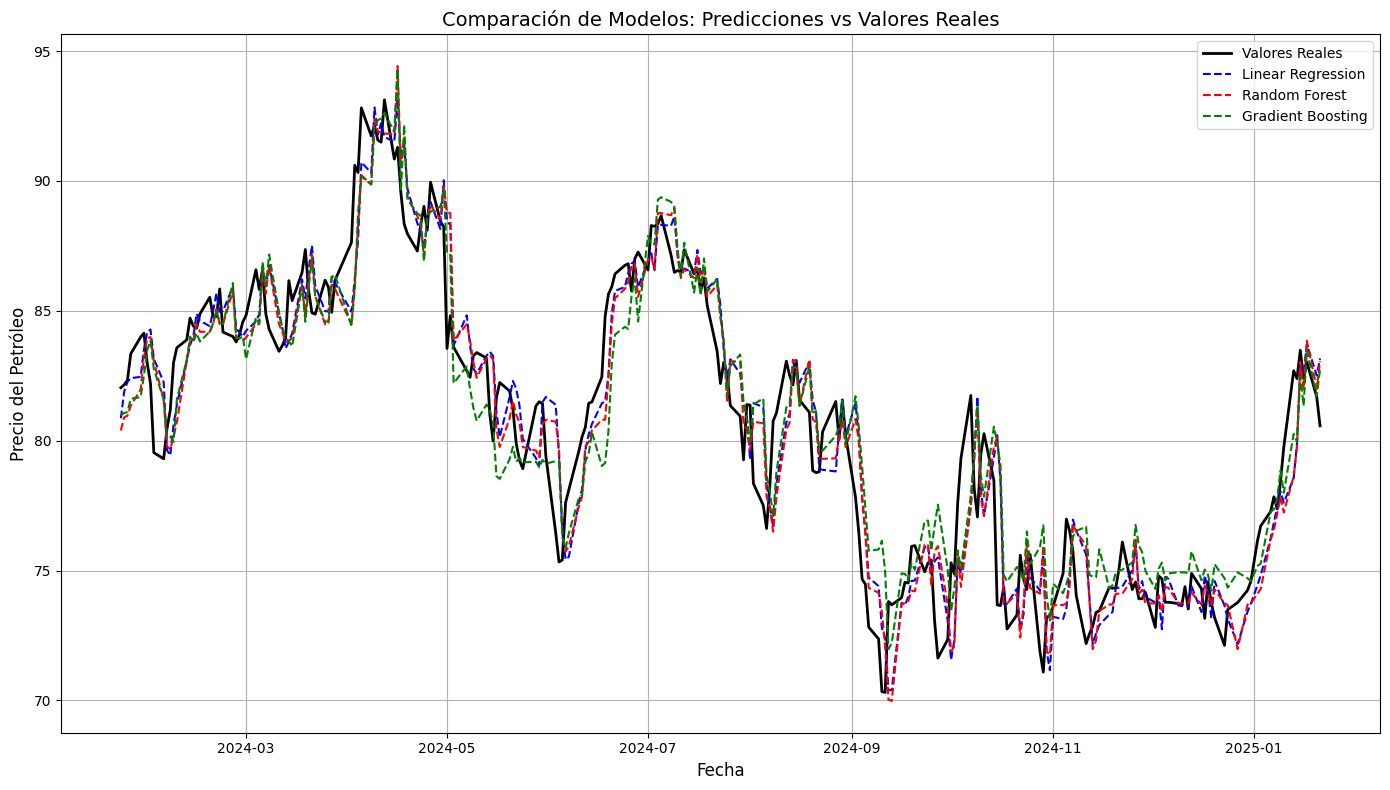

In [36]:
# Graficar comparación de modelos
plt.figure(figsize=(14, 8))
plt.plot(pred_df['Fecha'], pred_df['Reales'], 'k-', linewidth=2, label='Valores Reales')
plt.plot(pred_df['Fecha'], pred_df['Linear Regression'], 'b--', label='Linear Regression')
plt.plot(pred_df['Fecha'], pred_df['Random Forest'], 'r--', label='Random Forest')
plt.plot(pred_df['Fecha'], pred_df['Gradient Boosting'], 'g--', label='Gradient Boosting')

plt.title('Comparación de Modelos: Predicciones vs Valores Reales', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio del Petróleo', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig('../reports/figures/model_comparison.png', dpi=300)
plt.show()

In [37]:
# Registrar la comparación en MLflow
with mlflow.start_run(run_name="Model_Comparison"):
    mlflow.log_artifact('../reports/figures/model_comparison.png')

In [38]:
# Mostrar información sobre cómo acceder a la interfaz de MLflow
print("\n=== Instrucciones para visualizar en MLflow ===")
print("1. Abre una nueva terminal")
print("2. Ejecuta el comando: mlflow ui")
print("3. Abre en tu navegador: http://localhost:5000")
print("4. Explora los resultados del experimento 'Prediccion_Precios_Petroleo'")


=== Instrucciones para visualizar en MLflow ===
1. Abre una nueva terminal
2. Ejecuta el comando: mlflow ui
3. Abre en tu navegador: http://localhost:5000
4. Explora los resultados del experimento 'Prediccion_Precios_Petroleo'


In [39]:
# Extraer y guardar las métricas comparativas de los modelos
model_metrics = {
    "Modelo": ["Linear Regression", "Random Forest", "Gradient Boosting", "SVR"],
    "MSE (Test)": [
        mean_squared_error(y_test, test_predictions['Linear Regression']),
        mean_squared_error(y_test, test_predictions['Random Forest']),
        mean_squared_error(y_test, test_predictions['Gradient Boosting']),
        test_mse  # Del último modelo evaluado (SVR)
    ],
    "MAE (Test)": [
        mean_absolute_error(y_test, test_predictions['Linear Regression']),
        mean_absolute_error(y_test, test_predictions['Random Forest']),
        mean_absolute_error(y_test, test_predictions['Gradient Boosting']),
        test_mae  # Del último modelo evaluado (SVR)
    ],
    "R² (Test)": [
        r2_score(y_test, test_predictions['Linear Regression']),
        r2_score(y_test, test_predictions['Random Forest']),
        r2_score(y_test, test_predictions['Gradient Boosting']),
        test_r2  # Del último modelo evaluado (SVR)
    ]
}


In [40]:
# Crear DataFrame de métricas
metrics_df = pd.DataFrame(model_metrics)
print("\n=== Comparación de Métricas de Modelos ===")
print(metrics_df)


=== Comparación de Métricas de Modelos ===
              Modelo  MSE (Test)  MAE (Test)  R² (Test)
0  Linear Regression    3.605919    1.491001   0.877487
1      Random Forest    3.715413    1.517445   0.873766
2  Gradient Boosting    4.230511    1.595623   0.856266
3                SVR    7.503424    2.227670   0.745066


In [41]:
# Guardar tabla de métricas
metrics_df.to_csv('../reports/model_metrics_comparison.csv', index=False)
print("\nTabla de métricas guardada en '../reports/model_metrics_comparison.csv'")


Tabla de métricas guardada en '../reports/model_metrics_comparison.csv'


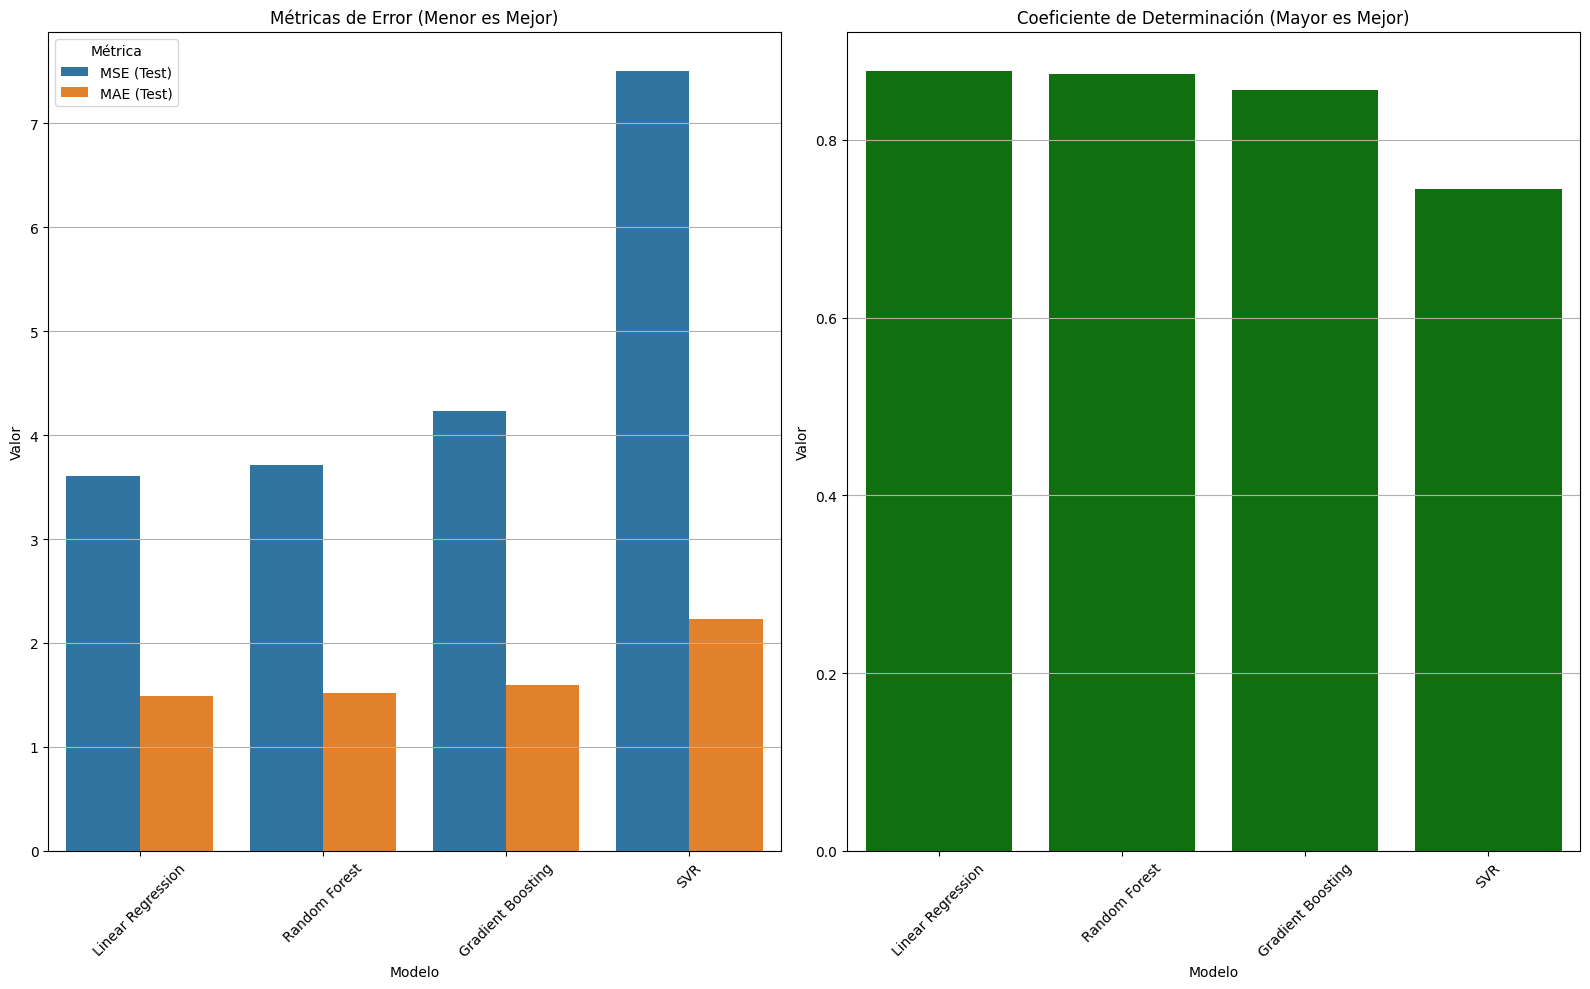

In [42]:
# Crear visualización de métricas de modelos
metrics_df_melted = pd.melt(metrics_df, id_vars=['Modelo'], value_vars=['MSE (Test)', 'MAE (Test)', 'R² (Test)'],
                          var_name='Métrica', value_name='Valor')

plt.figure(figsize=(16, 10))

# Subplot para MSE y MAE (escala más baja es mejor)
plt.subplot(1, 2, 1)
error_metrics = metrics_df_melted[metrics_df_melted['Métrica'].isin(['MSE (Test)', 'MAE (Test)'])]
sns.barplot(x='Modelo', y='Valor', hue='Métrica', data=error_metrics)
plt.title('Métricas de Error (Menor es Mejor)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')

# Subplot para R² (escala más alta es mejor)
plt.subplot(1, 2, 2)
r2_metrics = metrics_df_melted[metrics_df_melted['Métrica'] == 'R² (Test)']
sns.barplot(x='Modelo', y='Valor', data=r2_metrics, color='green')
plt.title('Coeficiente de Determinación (Mayor es Mejor)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')

plt.tight_layout()
plt.savefig('../reports/figures/metrics_comparison.png', dpi=300)
plt.show()

In [43]:
# Registrar esta visualización en MLflow
with mlflow.start_run(run_name="Metrics_Comparison"):
    mlflow.log_artifact('../reports/figures/metrics_comparison.png')
    mlflow.log_artifact('../reports/model_metrics_comparison.csv')

print("\n¡Evaluación de modelos completada con éxito!")
print("Consulta la interfaz de MLflow para ver y comparar los resultados detallados de los cuatro modelos.")


¡Evaluación de modelos completada con éxito!
Consulta la interfaz de MLflow para ver y comparar los resultados detallados de los cuatro modelos.


In [76]:
# Código para extraer modelos de MLflow y guardarlos en la carpeta models/
# Crear directorio models si no existe
os.makedirs('../models', exist_ok=True)

# Obtener el experimento actual
experiment = mlflow.get_experiment_by_name("Prediccion_Precios_Petroleo")
if experiment:
    # Obtener las ejecuciones (runs) del experimento
    runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    
    # Encontrar la última ejecución para cada modelo
    lr_runs = runs[runs['tags.mlflow.runName'] == "Linear_Regression_Model"].sort_values('start_time', ascending=False)
    rf_runs = runs[runs['tags.mlflow.runName'] == "Random_Forest_Model"].sort_values('start_time', ascending=False)
    
    # Guardar el modelo de regresión lineal si existe
    if not lr_runs.empty:
        lr_run_id = lr_runs.iloc[0]['run_id']
        lr_model_path = f"../models/linear_regression_{datetime.now().strftime('%Y%m%d')}.pkl"
        
        # Cargar el modelo desde MLflow
        lr_model = mlflow.sklearn.load_model(f"runs:/{lr_run_id}/linear_regression_model")
        
        # Guardar el modelo usando pickle
        with open(lr_model_path, 'wb') as f:
            pickle.dump(lr_model, f)
        print(f"Modelo de Regresión Lineal guardado en: {lr_model_path}")
        
        # Copiar métricas principales
        print(f"MSE (Test): {lr_runs.iloc[0]['metrics.test_mse']:.2f}")
        print(f"R² (Test): {lr_runs.iloc[0]['metrics.test_r2']:.4f}")
    
    # Guardar el modelo Random Forest si existe
    if not rf_runs.empty:
        rf_run_id = rf_runs.iloc[0]['run_id']
        rf_model_path = f"../models/random_forest_{datetime.now().strftime('%Y%m%d')}.pkl"
        
        # Cargar el modelo desde MLflow
        rf_model = mlflow.sklearn.load_model(f"runs:/{rf_run_id}/random_forest_model")
        
        # Guardar el modelo usando pickle
        with open(rf_model_path, 'wb') as f:
            pickle.dump(rf_model, f)
        print(f"Modelo Random Forest guardado en: {rf_model_path}")
        
        # Copiar métricas principales
        print(f"MSE (Test): {rf_runs.iloc[0]['metrics.test_mse']:.2f}")
        print(f"R² (Test): {rf_runs.iloc[0]['metrics.test_r2']:.4f}")
else:
    print("No se encontró el experimento 'Prediccion_Precios_Petroleo'")

Modelo de Regresión Lineal guardado en: ../models/linear_regression_20250302.pkl
MSE (Test): 3.61
R² (Test): 0.8775
Modelo Random Forest guardado en: ../models/random_forest_20250302.pkl
MSE (Test): 3.72
R² (Test): 0.8737


#Análisis
### Análisis de Correlaciones

La correlación entre características y precio muestra que:
- `Price_Lag_2` (precio de hace 2 días) tiene una correlación muy alta de 0.998.
- `Year` tiene una correlación moderada-alta de 0.729.

### Comparación de Modelos

1. **Regresión Lineal**:
   - Presnto un mejor rendimiento (R² = 0.877, MSE = 3.61)
   - Presento mayor consistencia entre entrenamiento y validación

2. **Random Forest**:
   - Rendimiento ligeramente inferior al modelo lineal en prueba (R² = 0.874, MSE = 3.72)
   - MayoSe pudo observar mayor sobreajuste: excelente en entrenamiento (R² = 0.988) pero cae en validación (R² = 0.621)
   - MAE parecido al modelo lineal (1.52)

3. **Gradient Boosting**:
   - Tercer mejor modelo en el conjunto de prueba (R² = 0.856, MSE = 4.23)
   - Se observa que de los 4 modelos este tiene un mayor sobreajuste: R² de 0.995 en entrenamiento vs 0.579 en validación
   - MAE (1.60)

4. **SVR (Support Vector Regression)**:
   - REsultado no satisfactorio en comparaciónm  con los otros modelos en cuanto al rendimiento en prueba (R² = 0.745, MSE = 7.50)
   - MAE mas alto (2.23), puede indicar predicciones menos precisas

### Observaciones clave

1. **Fenómeno de sobreajuste**: 

2. **Predominancia del modelo lineal**: Sorprendentemente, el modelo más simple (regresión lineal) obtiene el mejor resultado. Esto sugiere que la relación entre las características seleccionadas y el precio del petróleo es predominantemente lineal.

3. **Discrepancia en validación vs prueba**: Todos los modelos tienen un desempeño mucho mejor en el conjunto de prueba que en validación. Esto podría indicar:
   - El conjunto de validación contiene periodos más volátiles
   - La división de datos para validación cruzada no respeta adecuadamente la naturaleza temporal de los datos

4. **Orden de rendimiento**: Regresión Lineal > Random Forest > Gradient Boosting > SVR

### Conclusión
  - Todos los modelos más complejos (RF, GB, SVR) muestran una gran diferencia entre rendimiento de entrenamiento y validación, indicando sobreajuste.
  - La regresión lineal muestra el comportamiento más estable.
  - El modelo más simple (regresión lineal) obtiene el mejor resultado.
  -  Todos los modelos tienen un desempeño mucho mejor en el conjunto de prueba que en validación

**Mejor modelo - Regresión Lineal**: Más estable.

